In [4]:
from openai import OpenAI 

# Introduction:
In this project, we aimed to develop a product recommendation system utilizing the OpenAI API. The recommendation system is designed to provide users with personalized product suggestions based on their interaction history and the features of products they have engaged with.

# Data Acquisition and Preprocessing:

The project began with acquiring product data from a JSON file containing information such as title, short description, price, category, and features. This data served as the foundation for our recommendation system.

In [33]:
import json

# Open a JSON file for reading
with open('G:\\2024\\New folder\\NLP\\NLP_\\NLP_\\OPANAI\\products.json', 'r') as json_file:
    products = json.load(json_file)

In [35]:
products[0:5]

[{'title': 'Smartphone X1',
  'short_description': 'The latest flagship smartphone with AI-powered features and 5G connectivity.',
  'price': 799.99,
  'category': 'Electronics',
  'features': ['6.5-inch AMOLED display',
   'Quad-camera system with 48MP main sensor',
   'Face recognition and fingerprint sensor',
   'Fast wireless charging']},
 {'title': 'Luxury Diamond Necklace',
  'short_description': 'Elegant necklace featuring genuine diamonds, perfect for special occasions.',
  'price': 1499.99,
  'category': 'Beauty',
  'features': ['18k white gold chain',
   '0.5 carat diamond pendant',
   'Adjustable chain length',
   'Gift box included']},
 {'title': 'RC Racing Car',
  'short_description': 'High-speed remote-controlled racing car for adrenaline-packed fun.',
  'price': 89.99,
  'category': 'Toys',
  'features': ['Top speed of 30 mph',
   'Responsive remote control',
   'Rechargeable battery',
   'Durable construction']},
 {'title': 'Ultra HD 4K TV',
  'short_description': 'Imme

# Generating Embeddings:

We utilized OpenAI's powerful text-embedding capabilities to represent each product's features as dense vectors. This was accomplished by sending the product features to the OpenAI API, which returned embeddings representing semantic features of the text.

In [6]:
# Set your API key
client = OpenAI(api_key="your_api_key")

# Extract a list of product short descriptions from products
product_descriptions = [product['short_description']  for product in products ]

# Create embeddings for each product description
response = client.embeddings.create( 
    model="text-embedding-ada-002",
    input=product_descriptions)
response_dict = response.model_dump()
#print(response_dict)
# Extract the embeddings from response_dict and store in products
for i, product in enumerate(products):
    product['embedding'] = response_dict['data'][i]['embedding']
    
print(products[0].keys())

dict_keys(['title', 'short_description', 'price', 'category', 'features', 'embedding'])


# Visualizing Product Embeddings:

To gain insights into the structure of the product space, we applied t-SNE dimensionality reduction technique to visualize the embeddings in a two-dimensional space. This visualization helped us understand the relationships between products based on their textual features.

In [12]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\hp\AppData\Local\Temp\ipykernel_12032\191349208.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Visualizing the embedded descriptions

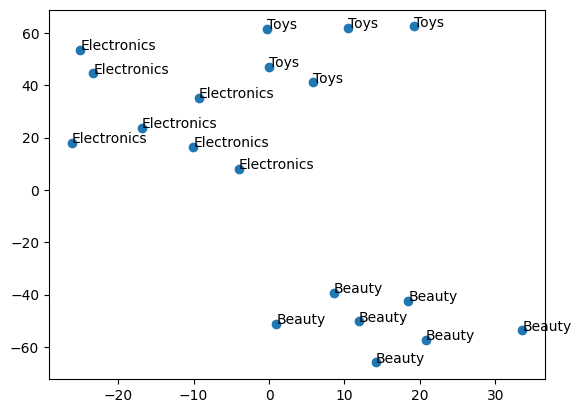

In [13]:
categories = [product['category'] for product in products]
embeddings = [product['embedding'] for product in products]

# Reduce the number of embeddings dimensions to two using t-SNE
tsne = TSNE(n_components=2, perplexity=5)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

# Create a scatter plot from embeddings_2d
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

for i, category in enumerate(categories):
    plt.annotate(category, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.show()

In [ ]:
Notice that the embedded product descriptions are broadly clustered by category!

# Recommendation Engine:

The recommendation engine consists of two main components:

Finding Similar Products to a Given Product:
We implemented a function that takes a product as input, generates embeddings for its features, and finds the most similar products based on cosine similarity between embeddings.

Recommendation based on User Interaction History:
We simulated a user's interaction history with products and used this history to recommend new products. First, we calculated the mean embedding of the user's interaction history. Then, we compared this mean embedding with the embeddings of all products to find the most similar ones.

In [15]:
# Define a create_embeddings function
def create_embeddings(texts):
  response = client.embeddings.create(
    model="text-embedding-ada-002",
    input=texts
  )
  response_dict = response.model_dump()

  return [data['embedding'] for data in response_dict['data']]

In [18]:
# Define a function to combine the relevant features into a single string
def create_product_text(product):
  return f"""Title: {product['title']}
Description: {product['short_description']}
Category: {product['category']}
Features: {', '.join(product['features'])}"""

# Combine the features for each product

product_texts = [create_product_text(product) for product in products]
print(product_texts[0])
product_embeddings = create_embeddings(product_texts)
#product_embeddings[0] # this is a huge result

Title: Smartphone X1
Description: The latest flagship smartphone with AI-powered features and 5G connectivity.
Category: Electronics
Features: 6.5-inch AMOLED display, Quad-camera system with 48MP main sensor, Face recognition and fingerprint sensor, Fast wireless charging


In [20]:
from scipy.spatial import distance

In [21]:
# define a function for measuring cosine similarity 
def find_n_closest(query_vector, embeddings, n=3):
  distances = []
  for index, embedding in enumerate(embeddings):
    # Calculate the cosine distance between the query vector and embedding
    dist = distance.cosine(query_vector, embedding)
    # Append the distance and index to distances
    distances.append({"distance": dist, "index": index})
  # Sort distances by the distance key
  distances_sorted = sorted(distances, key=lambda x: x["distance"])
  # Return the first n elements in distances_sorted
  return distances_sorted[0:n]

## Semantic search for products

In [22]:
# Create the query vector from query_text
query_text = "computer"
query_vector = create_embeddings(query_text)[0]

# Find the five closest distances
hits = find_n_closest(query_vector, product_embeddings, 5)

print(f'Search results for "{query_text}"')
for hit in hits:
  # Extract the product at each index in hits
  product = products[hit['index']]
  print(product["title"])

Search results for "computer"
High-Performance Gaming Laptop
Interactive Robot Pet
Remote-Controlled Drone
Wireless Charging Dock
Robot Building Kit


## Recommentdation System

In [23]:
# define a random user history to check the engine
last_product={'title': 'Building Blocks Deluxe Set',
 'short_description': 'Unleash your creativity with this deluxe set of building blocks for endless fun.',
 'price': 34.99,
 'category': 'Toys',
 'features': ['Includes 500+ colorful building blocks',
  'Promotes STEM learning and creativity',
  'Compatible with other major brick brands',
  'Comes with a durable storage container',
  'Ideal for children ages 3 and up']}


In [24]:
# Combine the features for last_product and each product in products
last_product_text = create_product_text(last_product)
product_texts = [create_product_text(product) for product in products]

# Embed last_product_text and product_texts
last_product_embeddings = create_embeddings(last_product_text)[0]
product_embeddings = create_embeddings(product_texts)

# Find the three smallest cosine distances and their indexes
hits = find_n_closest(last_product_embeddings, product_embeddings)

for hit in hits:
  product = products[hit['index']]
  print(product['title'])

LEGO Space Shuttle
Robot Building Kit
Luxury Skincare Set


Congratulations on making our first recommendation engine! As we can see, we were able to make very relevant recommendations based on the last product that the user viewed, a set of building blocks.
### Adding user history to the recommendation engine
For many recommendation cases, such as film or purchase recommendation, basing the next recommendation on one data point will be insufficient. In these cases, you'll need to embed all or some of the user's history for more accurate and relevant recommendations.

In [25]:
import numpy as np
user_history=[{'title': 'Remote-Controlled Dinosaur Toy',
  'short_description': 'Roar into action with this remote-controlled dinosaur toy with lifelike movements.',
  'price': 49.99,
  'category': 'Toys',
  'features': ['Realistic dinosaur sound effects',
   'Walks and roars like a real dinosaur',
   'Remote control included',
   'Educational and entertaining']},
 {'title': 'Building Blocks Deluxe Set',
  'short_description': 'Unleash your creativity with this deluxe set of building blocks for endless fun.',
  'price': 34.99,
  'category': 'Toys',
  'features': ['Includes 500+ colorful building blocks',
   'Promotes STEM learning and creativity',
   'Compatible with other major brick brands',
   'Comes with a durable storage container',
   'Ideal for children ages 3 and up']}]

In [26]:

# Prepare and embed the user_history, and calculate the mean embeddings
history_texts = [create_product_text(product) for product in user_history]
history_embeddings = create_embeddings(history_texts)
mean_history_embeddings = np.mean(history_embeddings, axis=0) # mean the vectors of the previous search/seen results

# Filter products to remove any in user_history
products_filtered = [product for product in products if product not in user_history]

# Combine product features and embed the resulting texts
product_texts = [create_product_text(product) for product in products_filtered]
product_embeddings = create_embeddings(product_texts)

hits = find_n_closest(mean_history_embeddings, product_embeddings)

for hit in hits:
  product = products_filtered[hit['index']]
  print(product['title'])

Remote-Controlled Dinosaur Toy
Robot Building Kit
LEGO Space Shuttle


# Results:

The recommendation system successfully provided personalized product suggestions based on both individual product queries and user interaction history. By leveraging the semantic understanding encoded in the embeddings, the system offered relevant recommendations tailored to the user's preferences.

# Conclusion:

In conclusion, this project demonstrates the effectiveness of utilizing OpenAI's API for building a product recommendation system. By leveraging text embeddings, we were able to capture semantic relationships between products and provide personalized recommendations. Further improvements could include fine-tuning the recommendation algorithm, integrating feedback loops for continuous learning, and optimizing the visualization of product embeddings for better interpretability.

# Future Directions:

Potential future directions for this project include:

Experimenting with different models and hyperparameters for text embeddings.
Incorporating user feedback mechanisms to improve the accuracy of recommendations over time.
Exploring additional data sources or features to enhance the recommendation engine's understanding of user preferences.
Overall, this project serves as a foundation for building more sophisticated recommendation systems using OpenAI's powerful natural language processing capabilities.